Copyright (c) 2019 [윤기태]

https://github.com/yoonkt200/python-data-analysis

[MIT License](https://github.com/yoonkt200/python-data-analysis/blob/master/LICENSE.txt)

# (가제) 파이썬 데이터 분석

-----

# 3.1) 와인 종류 분류하기

### 바로가기

- [1. Winequality 데이터 살펴보기](#1.-Winequality-데이터-살펴보기)
    - [Winequality 데이터셋의 기본 정보]
    - [데이터 전처리]
    - [피처의 분포 탐색]
- [2. 화이트와인과 레드와인 분류하기](#2.-화이트와인과-레드와인-분류하기)
    - [Logistic Regression]
    - [Decision Tree]
- [3. 와인의 등급 분류하기](#3.-와인의-등급-분류하기)
    - [멀티 레이블의 분류 방법]
    - [순위가 있는 레이블의 분류 방법]
- [4. 더 나은 결과를 위한 방법들](#4.-더-나은-결과를-위한-방법들)
    - [피처 엔지니어링]
    - [더 좋은 알고리즘 사용하기]

-----

In [84]:
# -*- coding: utf-8 -*-

%matplotlib inline

import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# 1. Winequality 데이터 살펴보기

### [Winequality 데이터셋의 기본 정보]

In [85]:
# Data Source : https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/

red_path = "../data/winequality-red.csv"
white_path = "../data/winequality-white.csv"

red_df = pd.read_csv(red_path, sep=";")
white_df = pd.read_csv(white_path, sep=";")

In [86]:
red_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [87]:
white_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [88]:
print(red_df.shape)
print(white_df.shape)

(1599, 12)
(4898, 12)


-----

### [데이터 전처리]

##### 데이터 병합

In [89]:
# white = 1, red = 0
white_df['wine_kind'] = 1
red_df['wine_kind'] = 0

In [90]:
result_col = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
              'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
              'pH', 'sulphates', 'alcohol', 'quality', 'wine_kind']
df = pd.DataFrame(columns=result_col)
df = df.append(white_df)
df = df.append(red_df)
df['quality'] = df['quality'].astype('str')
df['wine_kind'] = df['wine_kind'].astype('int')
origin_df = df.copy()
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_kind
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1


-----

##### 피처 스케일링

In [91]:
pd.options.mode.chained_assignment = None

In [92]:
# 피처 각각에 대한 scaling을 수행합니다.
def standard_scaling(df, scale_columns):
    for col in scale_columns:
        series_mean = df[col].mean()
        series_std = df[col].std()
        df[col] = df[col].apply(lambda x: (x-series_mean)/series_std)

In [93]:
scale_columns = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
                 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
                 'pH', 'sulphates', 'alcohol']
result = standard_scaling(df, scale_columns)

In [94]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_kind
0,-0.166076,-0.423150,0.284664,3.206682,-0.314951,0.815503,0.959902,2.102052,-1.358944,-0.546136,-1.418449,6,1
1,-0.706019,-0.240931,0.147035,-0.807775,-0.200775,-0.931035,0.287595,-0.232314,0.506876,-0.277330,-0.831551,6,1
2,0.682405,-0.362411,0.559923,0.306184,-0.172231,-0.029596,-0.331634,0.134515,0.258100,-0.613338,-0.328496,6,1
3,-0.011807,-0.666110,0.009405,0.642474,0.056121,0.928182,1.242978,0.301255,-0.177258,-0.882144,-0.496181,6,1
4,-0.011807,-0.666110,0.009405,0.642474,0.056121,0.928182,1.242978,0.301255,-0.177258,-0.882144,-0.496181,6,1


-----

### [피처의 분포 탐색]

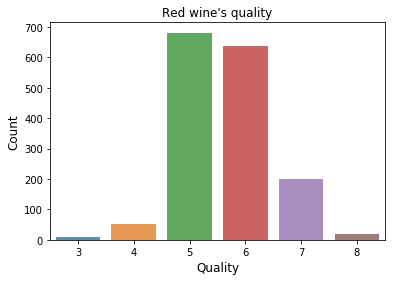

In [95]:
red_quality = df[df['wine_kind'] == 0]['quality'].value_counts().sort_index()

sns.barplot(red_quality.index, red_quality.values, alpha=0.8)
plt.title("Red wine's quality")
plt.ylabel("Count", fontsize=12)
plt.xlabel("Quality", fontsize=12)
plt.show()

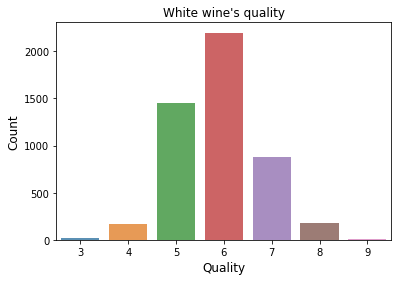

In [96]:
white_quality = df[df['wine_kind'] == 1]['quality'].value_counts().sort_index()

sns.barplot(white_quality.index, white_quality.values, alpha=0.8)
plt.title("White wine's quality")
plt.ylabel("Count", fontsize=12)
plt.xlabel("Quality", fontsize=12)
plt.show()

In [97]:
# 피처 각각에 대한 histogram을 그려줍니다.
def plot_hist_each_column(df):
    plt.rcParams['figure.figsize'] = [20, 16]
    fig = plt.figure(1)
    for i in range(len(df.columns)):
        ax = fig.add_subplot(4, 4, i+1)
        result = plt.hist(df[df.columns[i]], bins=100)
        ax.set_title(df.columns[i])
    plt.show()

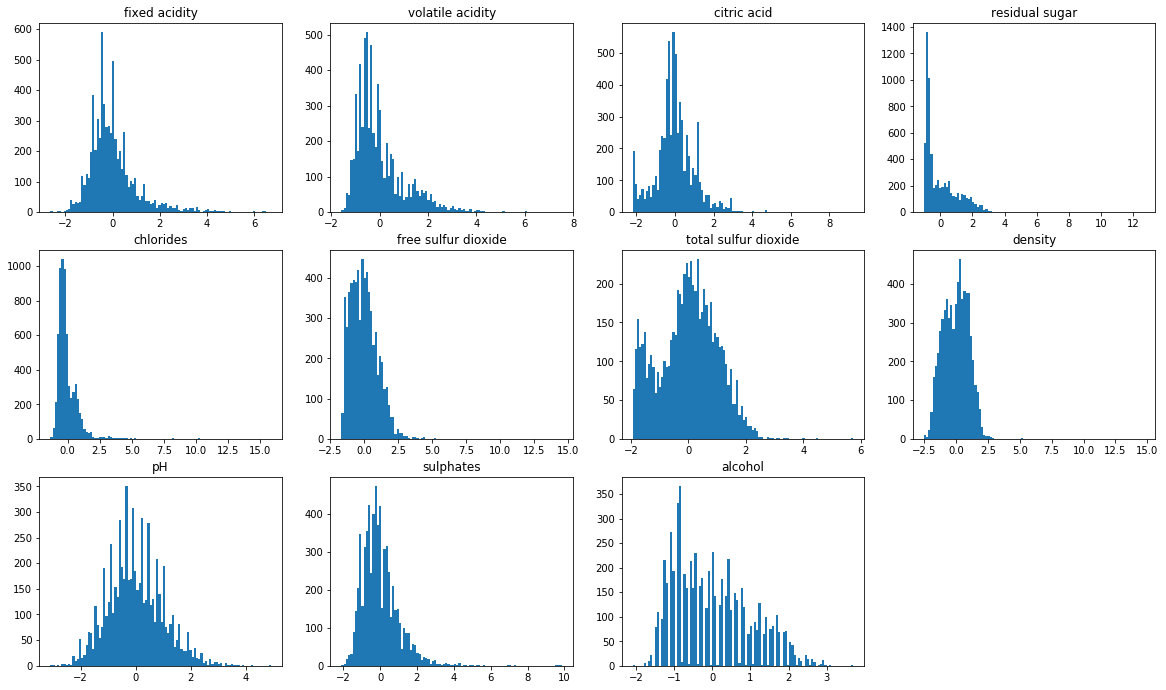

In [98]:
plot_hist_each_column(df[scale_columns])

-----

# 2. 화이트와인과 레드와인 분류하기

##### 모델링 프로세스
    - 훈련/테스트 데이터 분리
    - 훈련 데이터로 LogisticRegression 모델 학습
    - 테스트 데이터로 y값을 예측
    - 실제 y값과 예측된 y값을 비교하여 모델 평가

### [Logistic Regression]

In [99]:
# 훈련/테스트 데이터 분리
from sklearn.model_selection import train_test_split

x = df[scale_columns].values
y = df['wine_kind'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# 훈련 데이터로 LogisticRegression 모델 학습
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

lr = LogisticRegression()
lr.fit(x_train, y_train)

# 테스트 데이터로 y값을 예측
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1] # wine_kind가 "1"인지에 대한 확률

# 실제 y값과 예측된 y값을 비교하여 모델 평가
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

accuracy: 0.99
Precision : 0.996
Recall : 0.997
F1 : 0.996


-----

##### 분류 모델의 여러가지 평가 방법들
- Confusion Matrix 기반
    - Accuracy
    - Precision
    - Recall
    - F1 score
    - AUC (Area Under the Curve) & ROC (Receiver Operating Characteristic) curve

In [100]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[321   4]
 [  3 972]]


In [101]:
# AUC (Area Under the Curve) & ROC curve
from sklearn.metrics import roc_curve, roc_auc_score

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" % roc_auc)

AUC : 0.994


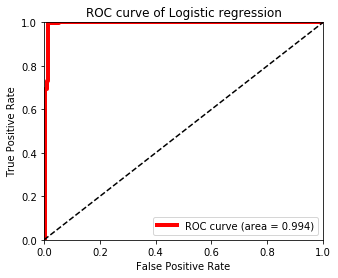

In [102]:
# ROC curve plot
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--') # 최하 기준선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")

-----

### [Decision Tree]

In [103]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)

y_pred = dtc.predict(x_test)
y_pred_probability = dtc.predict_proba(x_test)[:,1] # wine_kind가 "1"인지에 대한 확률

print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

accuracy: 0.98
Precision : 0.990
Recall : 0.989
F1 : 0.989


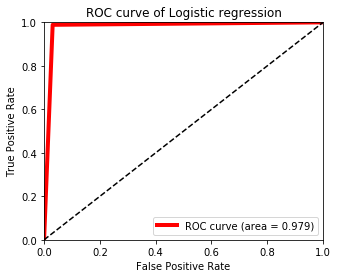

In [104]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)

plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")

-----

##### 참고 : Decision Tree 모델의 시각화

- install graphviz
    - Mac
        - 1. brew install : 
            - `(env_name)$ /usr/bin/ruby -e "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/master/install)"`
        - 2. install graphviz :
            - `(env_name)$ brew install graphviz`
    - Windows ??
    
- install pydotplus
    - `(env_name)$ pip install pydotplus`

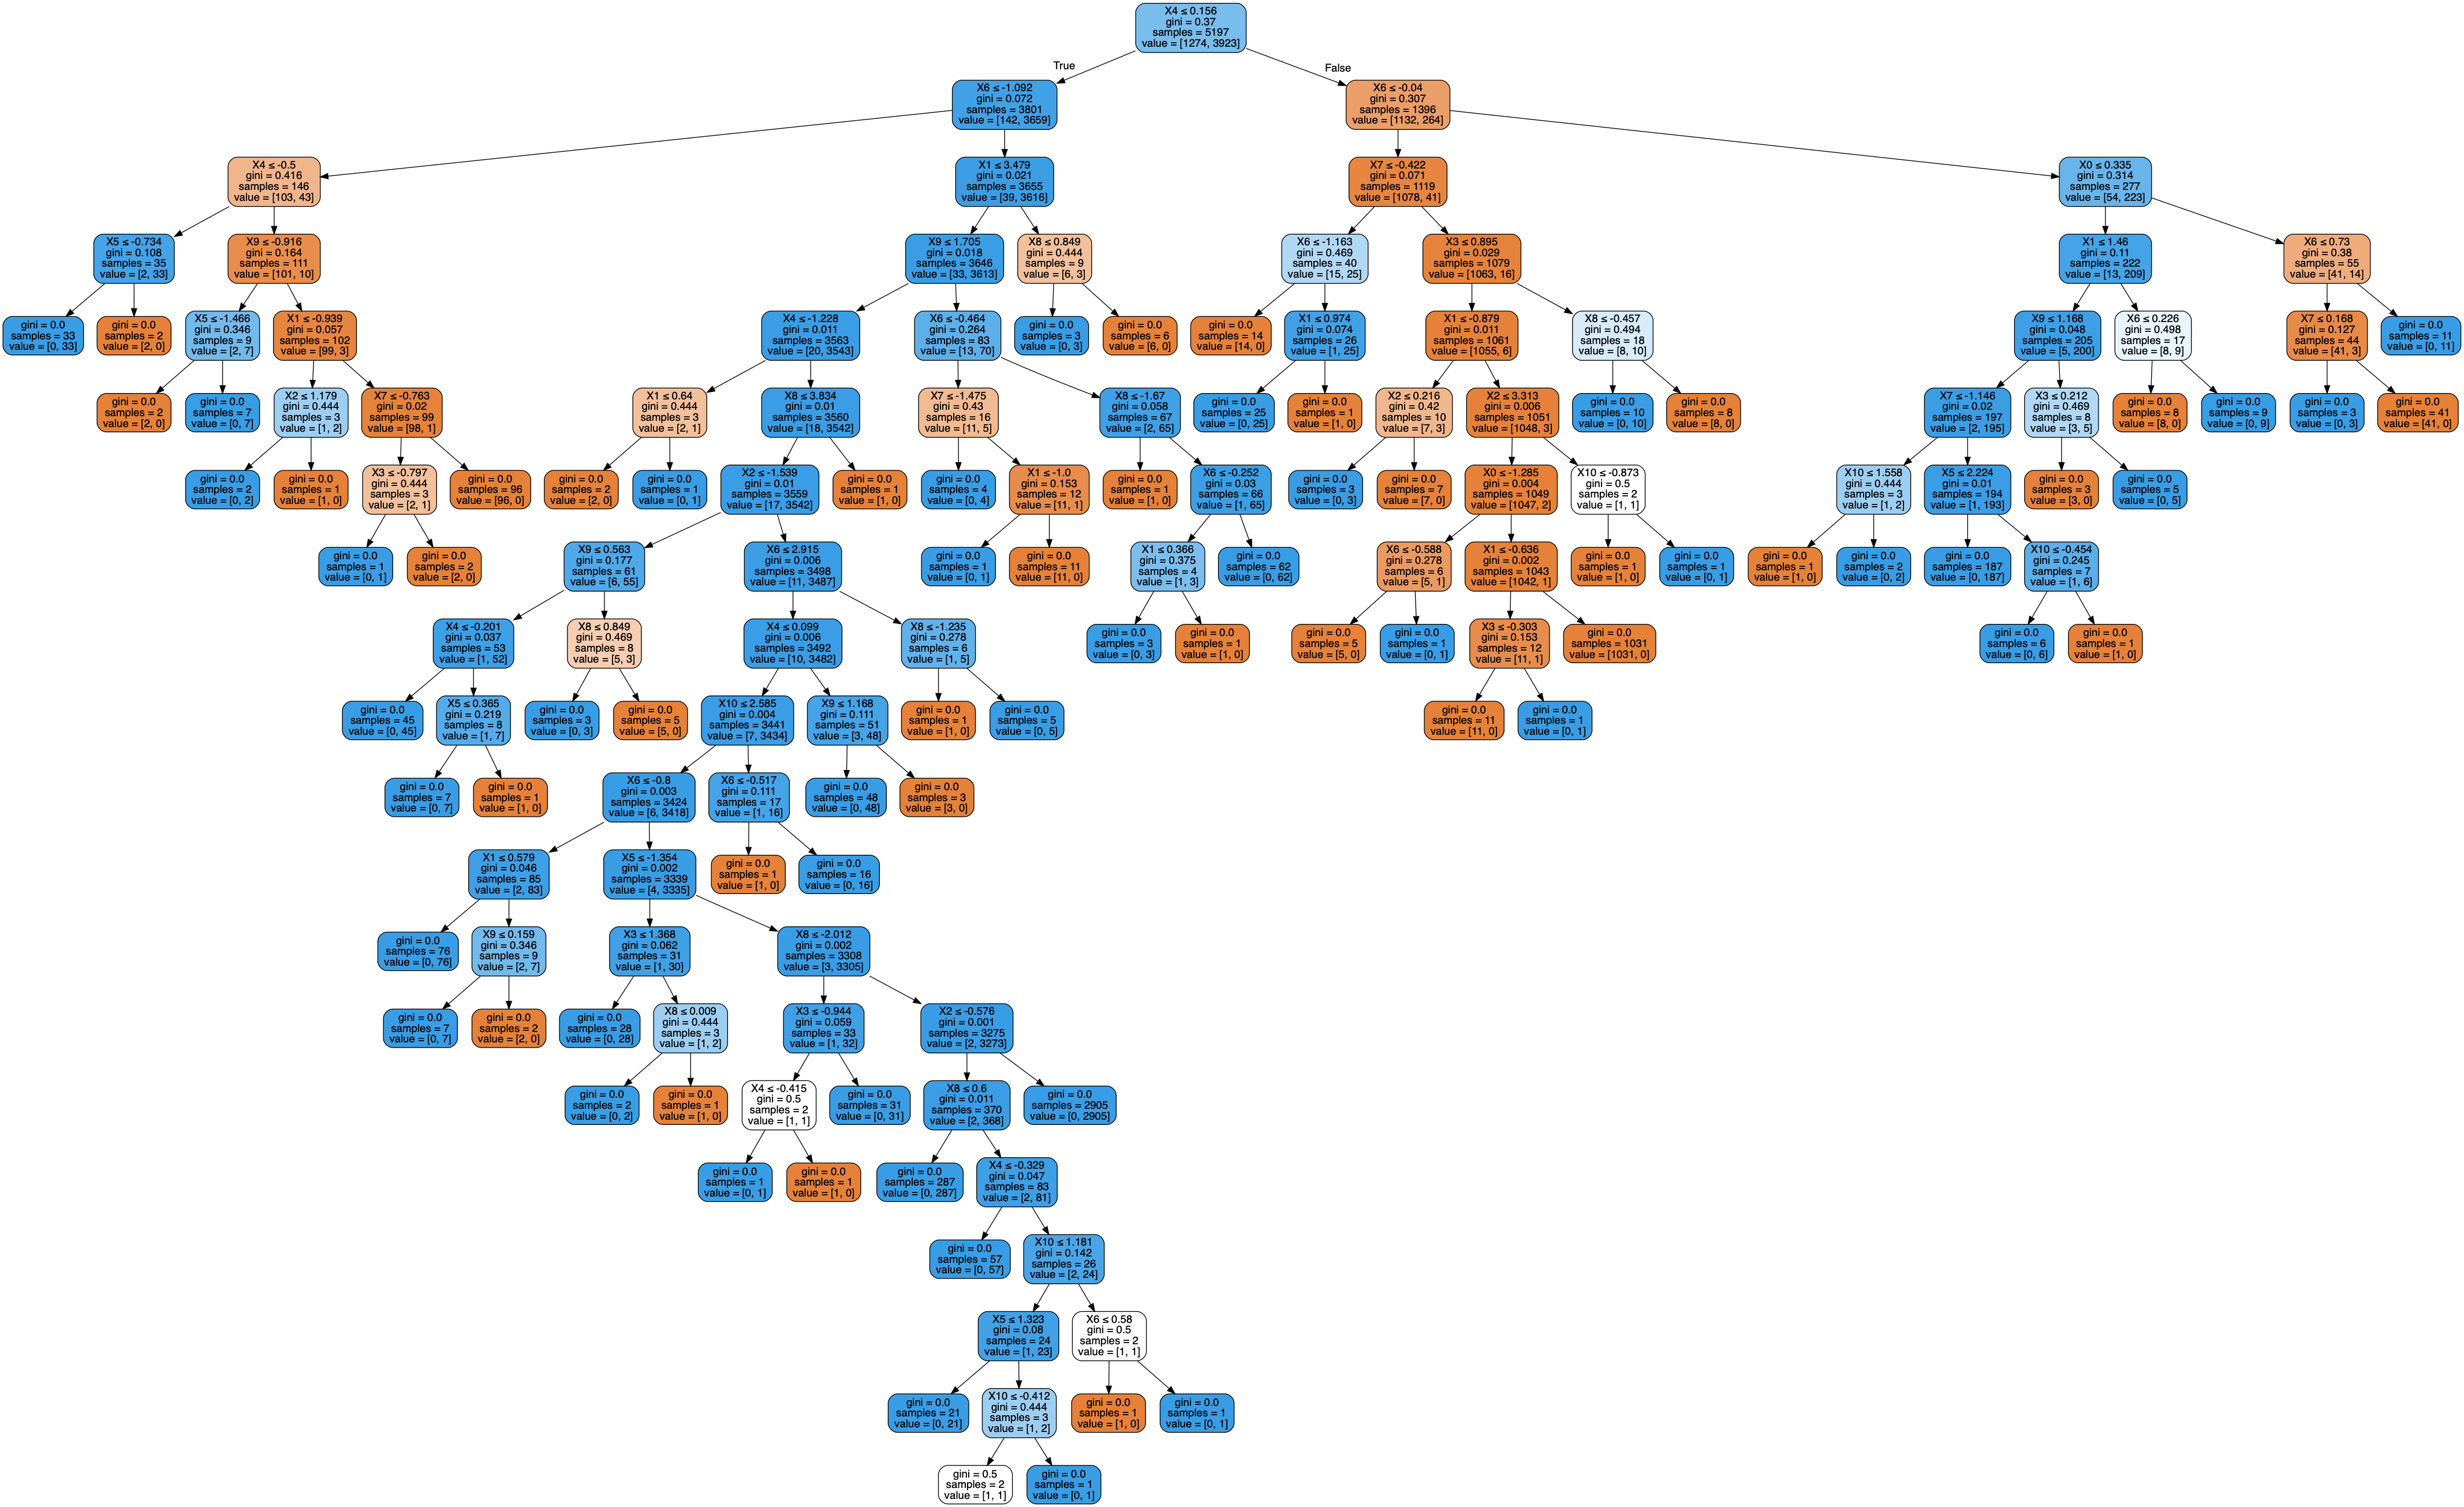

In [81]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

dot_data = export_graphviz(dtc, out_file=None, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

-----

# 3. 와인의 등급 분류하기

### [멀티 레이블의 분류 방법]

In [114]:
x = df[scale_columns].values
y = df['quality'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [115]:
y

array(['6', '6', '6', ..., '6', '5', '6'], dtype=object)

In [122]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)

y_pred = dtc.predict(x_test)
y_pred_probability = dtc.predict_proba(x_test)

print("accuracy: %.2f" % accuracy_score(y_test, y_pred))

accuracy: 0.61


In [118]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[  0   0   4   1   0   1   0]
 [  0  11  17  18   1   0   0]
 [  2  15 296 104  19   2   0]
 [  1  10  96 346  85  17   2]
 [  0   5  15  68 122   5   0]
 [  0   0   2   8  10  17   0]
 [  0   0   0   0   0   0   0]]


In [126]:
for i in y_pred_probability:
    print(i)

[0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0.]
[0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0.]
[0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0.]
[0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0.]
[0. 0. 1. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0.]
[0. 0. 1. 0

[0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0.]
[0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0.]
[0. 0. 1. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0.]
[0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1. 0. 0.]
[0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 1. 0.]
[0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0

In [140]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(7):
    precision[i], recall[i], _ = precision_recall_curve(y_test==i,
                                                        y_pred_probability[:, i])
    average_precision[i] = average_precision_score(y_test==i, y_pred_probability[:, i])

# # A "micro-average": quantifying score on all classes jointly
# precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
#     y_pred_probability.ravel())
# average_precision["micro"] = average_precision_score(y_test, y_pred_probability,
#                                                      average="micro")
# print('Average precision score, micro-averaged over all classes: {0:0.2f}'
#       .format(average_precision["micro"]))

In [150]:
from sklearn.metrics import roc_curve, auc
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

iris = datasets.load_iris()
X, y = iris.data, iris.target

y = label_binarize(y, classes=[0,1,2])
n_classes = 3

# shuffle and split training and test sets
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.33, random_state=0)

# classifier
clf = OneVsRestClassifier(LinearSVC(random_state=0))
y_score = clf.fit(X_train, y_train).decision_function(X_test)

# print(y_test)
print(y_score)

# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(n_classes):
#     fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Plot of a ROC curve for a specific class
# for i in range(n_classes):
#     plt.figure()
#     plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
#     plt.plot([0, 1], [0, 1], 'k--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver operating characteristic example')
#     plt.legend(loc="lower right")
#     plt.show()

[[-2.76908688 -0.84934084  1.94836132]
 [-1.46037616  0.67132471 -1.53966642]
 [ 1.72933089 -1.42912498 -7.80620594]
 [-3.15022065  0.34053982  1.38468113]
 [ 1.21840201 -0.71347734 -6.50405011]
 [-3.25268429 -0.94227781  2.65322458]
 [ 1.38285292 -1.00253201 -6.77348322]
 [-1.74241761 -0.2861782  -1.14215173]
 [-1.88147301  0.13114653 -1.00528666]
 [-1.3255239  -0.16571015 -1.68292966]
 [-2.78001305  0.65515427  1.24536386]
 [-1.60130975 -0.47815966 -1.21085451]
 [-1.86663686  0.27415437 -0.65782073]
 [-1.82219967 -0.08338252 -0.86759089]
 [-1.91078014 -0.02866974 -0.4619753 ]
 [ 1.40160069 -0.82797796 -6.83676061]
 [-1.8079497  -0.23560944 -0.5474873 ]
 [-1.82708961  0.2811739  -0.3403588 ]
 [ 1.05678543 -0.53322926 -6.02309072]
 [ 1.58734219 -1.4394491  -7.37508633]
 [-2.47807199 -0.51778906  1.30404655]
 [-1.85522198 -0.33669778 -0.17338898]
 [ 0.84164173 -0.53169109 -5.6184479 ]
 [ 0.97182192 -0.35404108 -5.63843928]
 [-2.1801147  -0.32545045  0.20066197]
 [ 1.62747562 -1.13719481

-----

### [순위가 있는 레이블의 분류 방법]

-----

# 5. 더 나은 결과를 위한 방법들

### [피처 엔지니어링]

##### 피처 분포 정상화

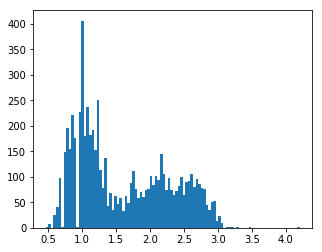

In [62]:
plt.rcParams['figure.figsize'] = [5, 4]
residual_sugar = origin_df['residual sugar'].apply(lambda x: math.log1p(x))
fig = plt.hist(residual_sugar, bins=100)

In [63]:
new_df = origin_df.copy()
new_df['residual sugar'] = new_df['residual sugar'].apply(lambda x: math.log1p(x))
result = standard_scaling(new_df, scale_columns)

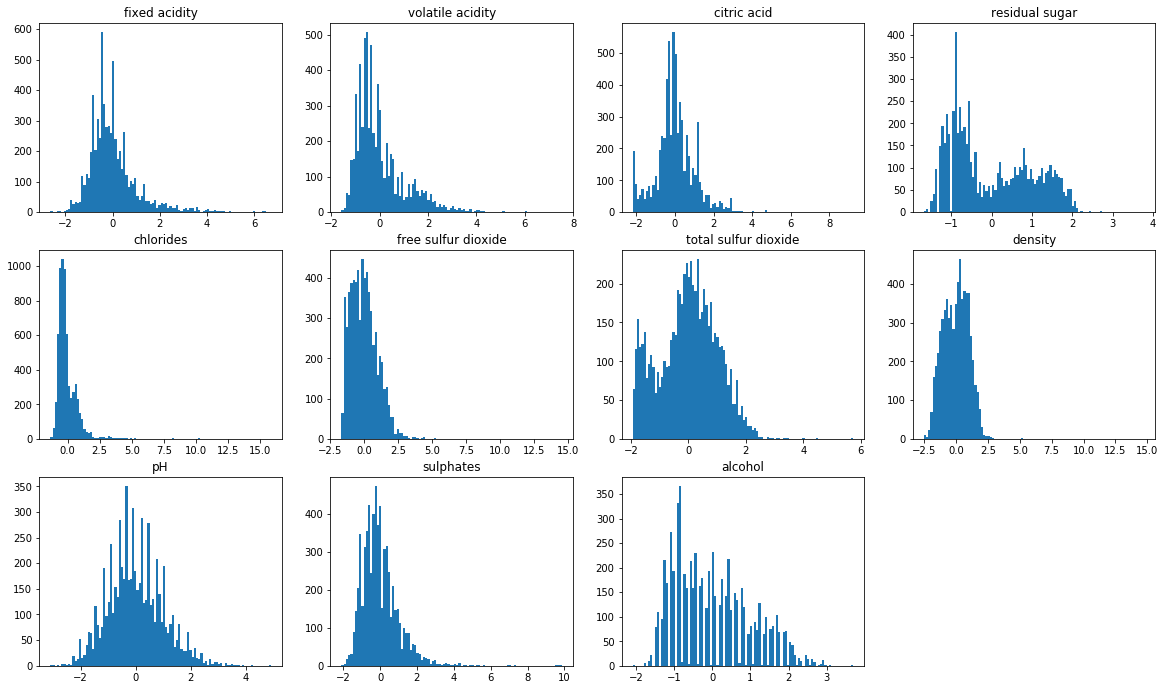

In [64]:
plot_hist_each_column(new_df[scale_columns])

-----

##### 이상치 제거

In [229]:
for col in scale_columns:
    new_df = new_df[abs(new_df[col]) < 5]

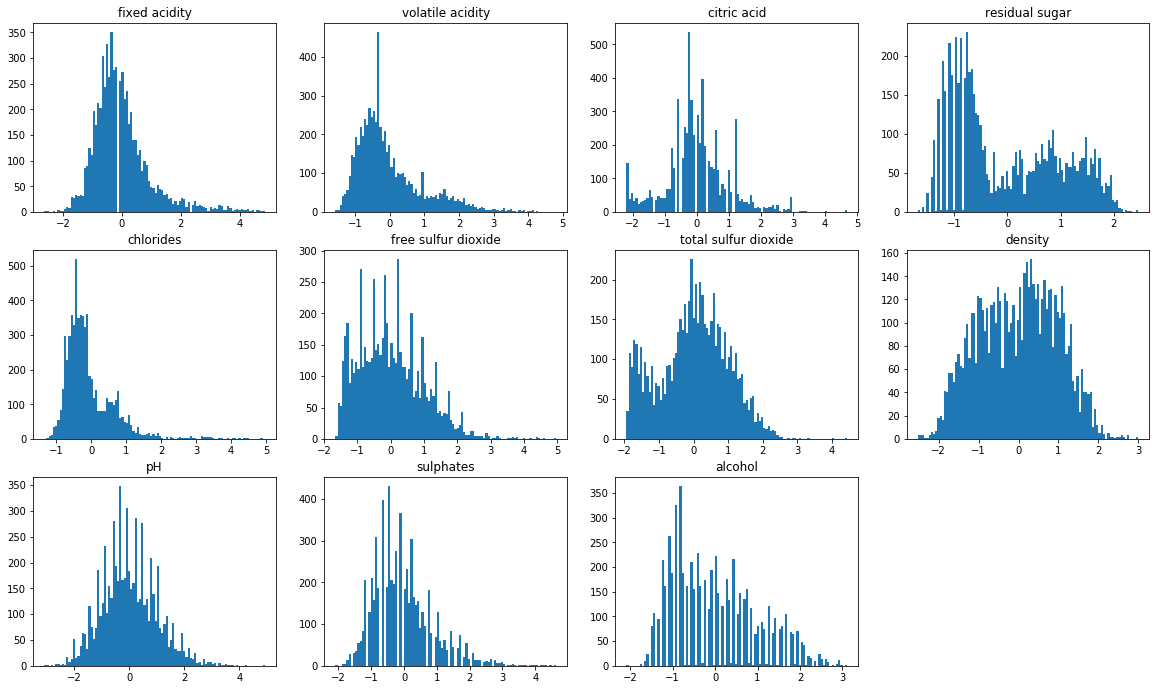

In [230]:
plot_hist_each_column(new_df[scale_columns])